In [1]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error


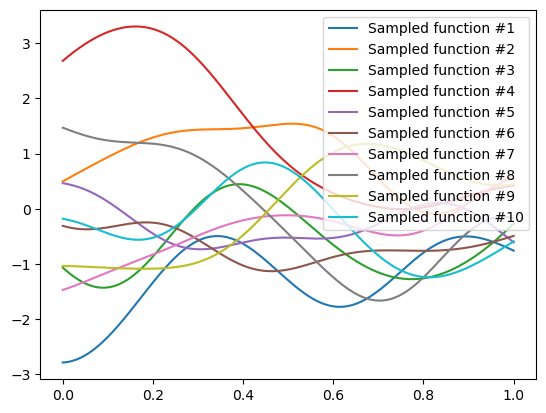

In [2]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1,10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)

N = 31 * 29 + 1
t = np.linspace(0,1,N)
dt = t[1]-t[0]

X = t.reshape(-1, 1)
n_samples=10

y_samples = gpr.sample_y(X, n_samples)

plt.figure()
for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        t,
        single_prior,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend()

forcing_terms = y_samples.T

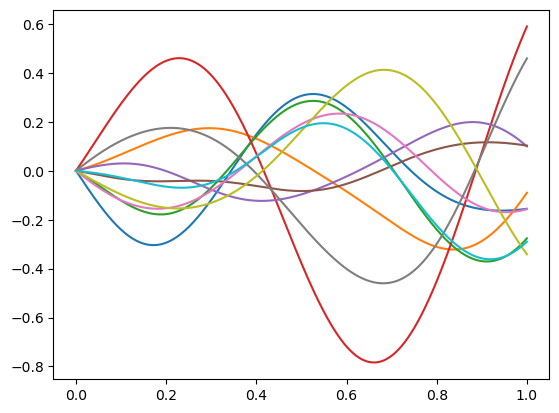

In [3]:
def f(t,u, force):
    k = 9.81/0.2
    u0 = u[1]
    u1 = -k*np.sin(u[0]) + force[int(t/dt)]
    U = np.array([u0, u1])
    return U

plt.figure()
solutions = []
for ft in forcing_terms:
    sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
    solutions.append(sol)
    plt.plot(sol.t, sol.y[1])


In [79]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class KernelModel(BaseEstimator, RegressorMixin):
    def __init__(self, nugget=1e-7, length_scale=1,):
        self.length_scale = length_scale
        self.nugget = nugget
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.K = RBF(length_scale=self.length_scale)
        UXX = self.K(self.X_, self.X_)
        UXX_nugget = (UXX + self.nugget ** 2 * np.eye(self.X_.shape[0]))
        self.UXX_inv_y = np.linalg.solve(UXX_nugget, self.y_)
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        UxX = self.K(X, self.X_)
        return UxX @ self.UXX_inv_y
    
    def set_params(self, **params):
        if not params:
            return self

        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)

        return self


In [6]:
ut = solutions[0].y[1]
u = solutions[0].y[0]
u_std = np.std(u)
noise = np.random.normal(0,0.1*u_std,N)
u_perturbed = u + noise
u_t_perturbed = ut + noise

scaler = StandardScaler()

t_sample = t[::31]
T_sample = t_sample.reshape(-1,1)
u_sample = u_perturbed[::31]
u_t_sample = u_t_perturbed[::31]

Best parameters found:  {'length_scale': 1.51}
Best estimator:  KernelModel(length_scale=1.51, nugget=5e-08)
Best cross-validation score:  -4.057350189602475e-06


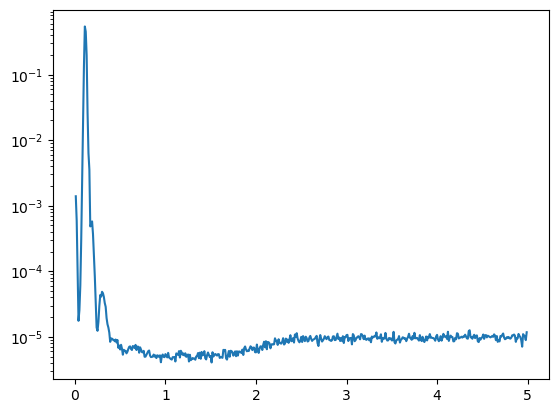

In [80]:
from sklearn.model_selection import GridSearchCV
l_range = np.arange(0.01,5, 0.01)
cv = ShuffleSplit(n_splits=10, random_state=0)
grid_search = GridSearchCV(estimator=KernelModel(5e-8, 1), param_grid={'length_scale': l_range}, cv=cv, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(T_sample, u_sample)

# Extract the best parameters and model
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)
print("Best cross-validation score: ", grid_search.best_score_)

results = grid_search.cv_results_
df = pd.DataFrame(results)
plt.figure()
plt.semilogy(l_range, -df['mean_test_score'])

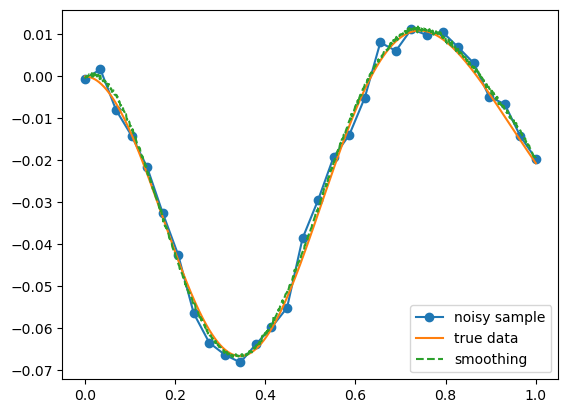

In [81]:
l = 1.51
eta = 5e-8
T = t.reshape(-1,1)
km = KernelModel(eta, l)
u_star = km.fit(T_sample, u_sample).predict(T)

plt.figure()
plt.plot(t_sample, u_sample, 'o-', label='noisy sample')
plt.plot(T, u, label='true data')
plt.plot(T, u_star, '--', label='smoothing')
plt.legend()

In [76]:
df['mean_test_score']

0     -0.001395
1     -0.000592
2     -0.000097
3     -0.000018
4     -0.000026
         ...   
494   -0.000011
495   -0.000011
496   -0.000010
497   -0.000009
498   -0.000012
Name: mean_test_score, Length: 499, dtype: float64

0     -0.001395
1     -0.000592
2     -0.000097
3     -0.000018
4     -0.000026
         ...   
494   -0.000011
495   -0.000011
496   -0.000010
497   -0.000009
498   -0.000012
Name: mean_test_score, Length: 499, dtype: float64